In [3]:
import pandas as pd
import numpy as np
import torch
import torch.functional as F
import torch.nn as nn 
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from torch.utils.data import Dataset, random_split, DataLoader, WeightedRandomSampler
import os
from torch.utils.tensorboard import SummaryWriter
import time
import pickle
from imblearn.over_sampling import SMOTE, ADASYN
from pathlib import Path

In [4]:
ROOT_DIR = Path().resolve().parent
WORKING_DIR = Path().resolve()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Data Loading

In [5]:
def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    X_train = data["X_train"].copy()
    X_valid = data["X_valid"].copy()
    X_test = data["X_test"].copy()
    y_train = data["y_train"].copy()
    y_valid = data["y_valid"].copy()
    y_test = data["y_test"].copy()
    features = data['feature_selection'].copy()
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, features

In [6]:
ROOT_DIR = Path().resolve().parent
WORKING_DIR = Path().resolve()
data_path = ROOT_DIR / 'Data' / 'Final_data.pkl'

### 2. Create Dataset

In [7]:
class myDataSet(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.label = torch.tensor(label.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

### 3. Define Neural Network Structure

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),       
            nn.LeakyReLU(0.1),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),          

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(512, output_dim),
            nn.LogSoftmax(dim=1)      
        )
    
    def forward(self, x):
        return self.net(x)


### 4. Utility functions

In [9]:
def make_DataLoader(X, y, batch_size = 16):
    data = myDataSet(X, y)
    loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    return loader

In [ ]:
def model_training(X_train, y_train,
                   X_valid, y_valid, 
                   num_epoch = 50, 
                   learning_rate = 1e-4,
                   negative_weight = 0.25, 
                   class_weights = [0.25, 0.75],
                   log_frequently = 10,
                   random_seed = None):
    
    # create model
    model = NeuralNetwork(input_dim=X_train.shape[1], output_dim=2).to(device)
    
    # make data loader
    train_loader = make_DataLoader(X_train, y_train)
    valid_loader = make_DataLoader(X_valid, y_valid)
    
    # create class weights
    if negative_weight:
        class_weights = torch.tensor([negative_weight, 1 - negative_weight], dtype=torch.float32).to(device)
    else:
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        # train_labels = []
        # for _, label in train_loader:
        #     train_labels.extend(label.tolist())
        # class_counts = np.bincount(train_labels)  
        # class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
        # class_weights = class_weights / class_weights.sum() 
        # class_weights = class_weights.to(device)
    
    # loss function & optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)  
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # log score
    best_acc = 0.0
    best_roc_auc = 0.0
    best_f1_score = 0.0
    
    # random seed  
    if random_seed: 
        torch.random.manual_seed(random_seed)
        np.random.seed(random_seed)
    
    # save path & log path
    timestamp = int(time.time())
    n_features = X_train.shape[1]
    save_dir = ROOT_DIR / f'Models/NeuralNetwork/{n_features}_features__{timestamp}'
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(ROOT_DIR / 'Models' / 'NeuralNetwork' / 'runs', exist_ok=True)
    log_dir = ROOT_DIR / f'Models/NeuralNetwork/runs/{n_features}_features__{timestamp}'
    
    writer = SummaryWriter(log_dir=log_dir)   
    
    # train the model
    for epoch in range(num_epoch):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            
            loss = criterion(preds, y)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        y_pred = []
        
        # evaluation
        
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                y_pred.extend(preds.argmax(dim=1).tolist())
                
        avg_loss = total_loss / len(train_loader)
        
        acc_score = accuracy_score(y_valid, y_pred)
        roc_auc = roc_auc_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)

        writer.add_scalar("Loss/train", avg_loss, epoch)
        writer.add_scalar("Accuracy/valid", acc_score, epoch)
        writer.add_scalar("ROC-AUC/valid", roc_auc, epoch)
        writer.add_scalar("F1-Score/valid", f1, epoch)

        print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}, Accuracy = {acc_score:.4f}, ROC-AUC Score = {roc_auc:.4f}, F1-Score = {f1:.4f}")

        if acc_score > best_acc:
            best_acc = acc_score
            torch.save(model.state_dict(), save_dir / 'best_accuracy.pt')
            
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            torch.save(model.state_dict(), save_dir /'best_roc_auc.pt')
            
        if f1 > best_f1_score:
            best_f1_score = f1
            torch.save(model.state_dict(), save_dir / 'best_f1_score.pt')

        if (epoch + 1) % log_frequently == 0:
            torch.save(model.state_dict(), save_dir / f'epoch_{epoch}.pt')
    
    print(f"Training finished. Best Accuracy: {best_acc:.4f}, Best ROC-AUC Score: {best_roc_auc:.4f}, Best F1-Score: {best_f1_score:.4f}")
    
    writer.close()

### 5. Model Training

In [15]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
test_loader = make_DataLoader(X_test, y_test)

LOG_FREQUENTLY = 10

# Hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
NEGATIVE_WEIGHT = 0.25

In [12]:
model_training(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    num_epoch=NUM_EPOCHS, 
    learning_rate=LEARNING_RATE,
    negative_weight=NEGATIVE_WEIGHT,
    log_frequently=LOG_FREQUENTLY
)

Epoch 1: Loss = 0.6897, Accuracy = 0.7891, ROC-AUC Score = 0.6392, F1-Score = 0.3922
Epoch 2: Loss = 0.6413, Accuracy = 0.7755, ROC-AUC Score = 0.5473, F1-Score = 0.2326
Epoch 3: Loss = 0.6214, Accuracy = 0.7619, ROC-AUC Score = 0.5391, F1-Score = 0.2222
Epoch 4: Loss = 0.5929, Accuracy = 0.7551, ROC-AUC Score = 0.5351, F1-Score = 0.2174
Epoch 5: Loss = 0.5726, Accuracy = 0.7619, ROC-AUC Score = 0.5391, F1-Score = 0.2222
Epoch 6: Loss = 0.5818, Accuracy = 0.7687, ROC-AUC Score = 0.5935, F1-Score = 0.3200
Epoch 7: Loss = 0.5765, Accuracy = 0.7551, ROC-AUC Score = 0.5518, F1-Score = 0.2500
Epoch 8: Loss = 0.5655, Accuracy = 0.7483, ROC-AUC Score = 0.5645, F1-Score = 0.2745
Epoch 9: Loss = 0.5578, Accuracy = 0.7755, ROC-AUC Score = 0.5976, F1-Score = 0.3265
Epoch 10: Loss = 0.5141, Accuracy = 0.7415, ROC-AUC Score = 0.6108, F1-Score = 0.3448
Epoch 11: Loss = 0.5191, Accuracy = 0.7687, ROC-AUC Score = 0.6103, F1-Score = 0.3462
Epoch 12: Loss = 0.5068, Accuracy = 0.7483, ROC-AUC Score = 0.6

In [ ]:
# X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
# for X in [X_train, X_valid, X_test]:
#     X.drop(columns = ['Education', 'EducationField', 'Department', 'Gender', 'PerformanceRating'], inplace=True)

# test_loader = make_DataLoader(X_test, y_test)

# model_training(
#     X_train=X_train,
#     y_train=y_train,
#     X_valid=X_valid,
#     y_valid=y_valid,
#     num_epoch=NUM_EPOCHS, 
#     learning_rate=LEARNING_RATE,
#     negative_weight=NEGATIVE_WEIGHT,
#     log_frequently=LOG_FREQUENTLY
# )

Epoch 1: Loss = 0.6833, Accuracy = 0.7143, ROC-AUC Score = 0.6448, F1-Score = 0.3824
Epoch 2: Loss = 0.6106, Accuracy = 0.7347, ROC-AUC Score = 0.6738, F1-Score = 0.4179
Epoch 3: Loss = 0.5750, Accuracy = 0.7551, ROC-AUC Score = 0.6860, F1-Score = 0.4375
Epoch 4: Loss = 0.5698, Accuracy = 0.7619, ROC-AUC Score = 0.7068, F1-Score = 0.4615
Epoch 5: Loss = 0.5400, Accuracy = 0.7687, ROC-AUC Score = 0.6941, F1-Score = 0.4516
Epoch 6: Loss = 0.5259, Accuracy = 0.7415, ROC-AUC Score = 0.6778, F1-Score = 0.4242
Epoch 7: Loss = 0.5226, Accuracy = 0.7483, ROC-AUC Score = 0.6819, F1-Score = 0.4308
Epoch 8: Loss = 0.4952, Accuracy = 0.7687, ROC-AUC Score = 0.6941, F1-Score = 0.4516
Epoch 9: Loss = 0.5065, Accuracy = 0.7551, ROC-AUC Score = 0.6860, F1-Score = 0.4375
Epoch 10: Loss = 0.4885, Accuracy = 0.7551, ROC-AUC Score = 0.7027, F1-Score = 0.4545
Epoch 11: Loss = 0.4776, Accuracy = 0.7483, ROC-AUC Score = 0.6987, F1-Score = 0.4478
Epoch 12: Loss = 0.4605, Accuracy = 0.7687, ROC-AUC Score = 0.7

### 6. Model Evaluation

30 features

Accuracy score: 0.8231, ROC-AUC Score: 0.7181, f1-score: 0.5000


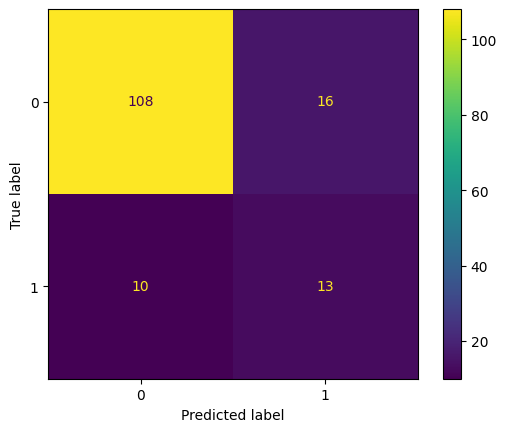

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
test_loader = make_DataLoader(X_test, y_test)

model = NeuralNetwork(input_dim=30, output_dim=2).to(device)
model.load_state_dict(torch.load(ROOT_DIR / 'Models/NeuralNetwork' / '30_features__1744091785' / 'best_model.pt'))

model.eval()
y_pred = []
with torch.no_grad():
    loader = test_loader
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        y_pred.extend(preds.argmax(dim=1).tolist())
        
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}, ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}, f1-score: {f1_score(y_test, y_pred):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

25 features

Accuracy score: 0.8163, ROC-AUC Score: 0.7495, f1-score: 0.5263


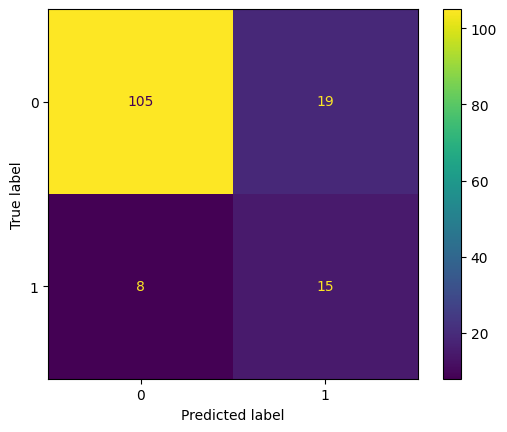

In [48]:
X_train, X_valid, X_test, y_train, y_valid, y_test, features = read_data(data_path)
for X in [X_train, X_valid, X_test]:
    X.drop(columns = ['Education', 'EducationField', 'Department', 'Gender', 'PerformanceRating'], inplace=True)

test_loader = make_DataLoader(X_test, y_test)

model = NeuralNetwork(input_dim=25, output_dim=2).to(device)
model.load_state_dict(torch.load(ROOT_DIR / 'Models/NeuralNetwork' / '25_features__1744414586' / 'best_model.pt'))

model.eval()
y_pred = []
with torch.no_grad():
    loader = test_loader
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        y_pred.extend(preds.argmax(dim=1).tolist())
        
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}, ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}, f1-score: {f1_score(y_test, y_pred):.4f}')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()